# Import packages

In [ ]:
#-------------Import packages-------------
import pandas as pd
import pandas_datareader as pdr #to extract data from yahoo finance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Load data

In [ ]:
#load data
Load_index_data = pd.read_pickle(r'C:\Users\hp\Desktop\01ai_project\data\KLSE_index.pkl')
Load_stock_data = pd.read_pickle(r'C:\Users\hp\Desktop\01ai_project\data\KLSE_stock.pkl')

#copying data
index_data = Load_index_data
stock_data = Load_stock_data

#extracting stock symbols
stock_symbols = stock_data.columns.values
print(stock_symbols)

#shape of data
print(stock_data.shape)
print(index_data.shape)


['4707.KL' '1155.KL' '1066.KL' '1295.KL' '6012.KL' '5819.KL' '1082.KL'
 '5183.KL' '5225.KL' '3816.KL' '5347.KL' '6033.KL' '4715.KL' '4863.KL'
 '3182.KL' '6888.KL' '8869.KL' '5681.KL' '3034.KL' '7277.KL' '2445.KL'
 '1961.KL' '4197.KL' '5285.KL' '5168.KL' '7113.KL' '4065.KL' '1023.KL'
 '6947.KL']
(958, 29)
(958,)


# spliting data

In [ ]:
#spliting data
# 80% of our data size
n_train = int(stock_data.shape[0]*0.8)

# spliting stock data with 80% for training and 20% for testing
stock_train = stock_data.values[:n_train, :]
stock_test = stock_data.values[n_train:, :]

# spliting index data with 80% for training and 20% for testing
index_train = index_data[:n_train]
index_test = index_data[n_train:]


# normalizing data

In [ ]:
#normalizing data
# Stocks data
scaler = MinMaxScaler([0, 1])
stock_train = scaler.fit_transform(stock_train)
stock_test = scaler.fit_transform(stock_test)
# Index data
scaler_index = MinMaxScaler([0, 1])
# np.newaxis used to increase the dimension (1D array will become 2D array and so on)
index_train = scaler_index.fit_transform(index_train[:, np.newaxis])
index_test = scaler_index.fit_transform(index_test[:, np.newaxis])

<ipython-input-6-ca40b5df4bf9>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  index_train = scaler_index.fit_transform(index_train[:, np.newaxis])
<ipython-input-6-ca40b5df4bf9>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  index_test = scaler_index.fit_transform(index_test[:, np.newaxis])


# Autoencoder

## Define model (functional API)

In [ ]:
# hyperparameters
n_inputs = stock_train.shape[1]
epochs =50
batch_size = 1

In [ ]:
# Define model (functional API)
inputs = Input(shape=(n_inputs,)) #(input neurons i.e number of columns)
encoded = Dense(8, input_shape=(n_inputs,), activation='relu', activity_regularizer=regularizers.l1(10e-5))(inputs)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(n_inputs, activation='sigmoid')(decoded) #(output = input)
# Encoder
encoder = Model(inputs, encoded)
# Autoencoder
model = Model(inputs, decoded)
# Compile autoencoder
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 29)                261       
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model (input and output both are training data)
history = model.fit(stock_train, stock_train,epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1)

Epoch 1/50
766/766 [==============================] - 1s 846us/step - loss: 0.0418
Epoch 2/50
766/766 [==============================] - 1s 780us/step - loss: 0.0255
Epoch 3/50
766/766 [==============================] - 1s 746us/step - loss: 0.0212
Epoch 4/50
766/766 [==============================] - 1s 730us/step - loss: 0.0192
Epoch 5/50
766/766 [==============================] - 1s 719us/step - loss: 0.0183
Epoch 6/50
766/766 [==============================] - 1s 739us/step - loss: 0.0178
Epoch 7/50
766/766 [==============================] - 1s 732us/step - loss: 0.0174
Epoch 8/50
766/766 [==============================] - 1s 734us/step - loss: 0.0166
Epoch 9/50
766/766 [==============================] - 1s 742us/step - loss: 0.0153
Epoch 10/50
766/766 [==============================] - 1s 755us/step - loss: 0.0131
Epoch 11/50
766/766 [==============================] - 1s 726us/step - loss: 0.0114
Epoch 12/50
766/766 [==============================] - 1s 736us/step - loss: 0.0105
E

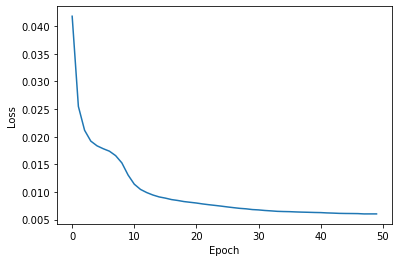

In [ ]:
# Visualize loss history
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Evaluate model

In [ ]:
#Evaluate model (evaluation and mean squared checking error of model)
score_train = model.evaluate(stock_train, stock_train, batch_size=batch_size)
score_test = model.evaluate(stock_test, stock_test, batch_size=batch_size)
print('Training MSE: %.8f' %score_train)
print('Testing MSE: %.8f' %score_test)

192/192 [==============================] - 0s 723us/step - loss: 0.0568
Training MSE: 0.00589742
Testing MSE: 0.05682172


## prediction

In [ ]:
#Obtain reconstruction of the stocks (predction and checking error)
stock_train_pred = model.predict(stock_train)
stock_test_pred = model.predict(stock_test)

#storing mean squared error of each stock of training data (actual - predicted)
error_train = np.mean(np.abs(stock_train - stock_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error_train)) #mean of all error

#storing mean squared error of each stock of test data (actual - predicted)
error_test = np.mean(np.abs(stock_test - stock_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test)) #mean of all error

Training MSE: 0.00560192
Testing MSE: 0.05657821


## sorting stocks on basis of errors 

In [ ]:
#--------- Sort stocks by reconstruction error
# sort on the basis of error
ind = np.argsort(error_train) #sort index number on basis of error
sort_error = error_train[ind]
sort_assets_names = stock_symbols[ind]

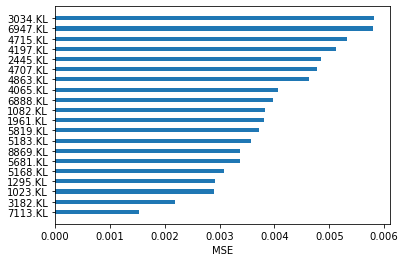

In [ ]:
# Barplot (top 20 stocks on the basis of error)
plt.figure('top 20 stocks on the basis of error')
plt.barh(2*np.arange(len(error_train[:20])), error_train[ind[:20]], tick_label=stock_symbols[ind[:20]])
plt.xlabel('MSE')
plt.show()

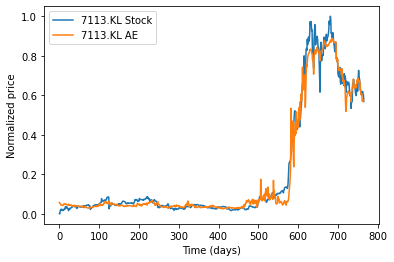

In [ ]:
# Plot lowest error stock
i=0 #(index = 0 is that stock which has least error)
plt.figure('Plot of stock with lowest error')
plt.plot(stock_train[:, ind[i]], label=stock_symbols[ind[i]] + ' Stock')
plt.plot(stock_train_pred[:, ind[i]], label=stock_symbols[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

# Index replication

## taking top stock

In [ ]:
#(taking top 5 stock)
n = 5 

#top 5 pred train data
portfolio_train = stock_train_pred[:, ind[:n]] 

#top 5 pred test data
portfolio_test = stock_test_pred[:, ind[:n]]  

# Create portfolio in-sample  (i.e. training data)
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample (i.e. test data)
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

## In-sample 

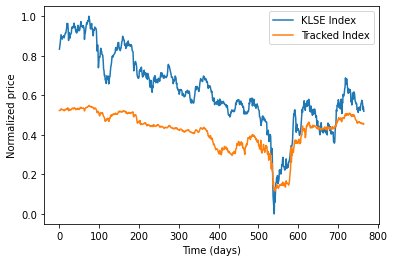

In [ ]:
# Plot tracked index (In-sample)
plt.figure('In-sample')
plt.plot(index_train, label='KLSE Index') #train data actual value
plt.plot(tracked_index_insample, label='Tracked Index') #train predected value
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [ ]:
# Correlation coefficient (in-sample) (checking correlation bw training actual and predicted value)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]#(range 0-1)
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.84987202


## outsample

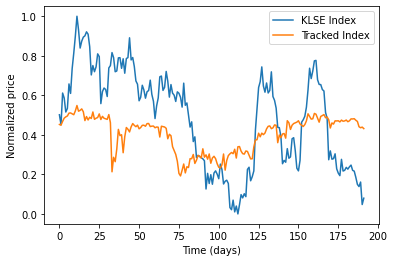

In [ ]:
# Plot tracked index (out-of-sample)
plt.figure('out-of-sample')
plt.plot(index_test, label='KLSE Index')  #test data actual value
plt.plot(tracked_index_outofsample, label='Tracked Index') #test predected value
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()

In [ ]:
# Correlation coefficient (out-of-sample) (checking correlation bw test actual and predicted value)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient (out-sample): %.8f' %corr_test)

Correlation coefficient (out-sample): 0.41359701


##Save and load the model

In [ ]:
model.save('model.h5')


In [ ]:
from tensorflow.keras.models import load_model
m1=load_model(r'model.h5')
m1.summary()